In [11]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, utils
from dsd import DSDTraining, UpdateMasks
# from utils import plot_wb, wb_non_zero_percentage

# Dataset

In [33]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
#train_x = train_x.reshape([train_x.shape[0], -1]) / 255.
#test_x = test_x.reshape([test_x.shape[0], -1]) / 255.
train_x = train_x[..., None] / 255.
test_x = test_x[..., None] / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

print(train_x.shape, test_x.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [51]:
import matplotlib.pyplot as plt

def plot_wb(model, ranges=None):
    
    # According to paper, first conv layer is ignored.
    for i, l in enumerate(model.layers[1:]):
        w = l.get_weights()[0].flatten()
        b = l.get_weights()[1].flatten()

        # Plot.
        fig = plt.figure(figsize=(15,5))

        fig.add_subplot(1,2,1)
        plt.title("weights " + l.name)
        plt.hist(w, bins=100, range=ranges);

        fig.add_subplot(1,2,2)
        plt.title("biases " + l.name)
        plt.hist(b, bins=100, range=ranges);

def wb_non_zero_percentage(model):

    for i, l in enumerate(model.layers):
        # Take all dense layer except last one,
        if i > 0 and ("conv" in l.name or "dense" in l.name):
            w, b = model.layers[0].get_weights()

            non_zero_w = tf.math.count_nonzero(w)
            total_w = tf.reshape(w, [-1]).shape[0]
            res_w = (non_zero_w / total_w).numpy() * 100

            non_zero_b = tf.math.count_nonzero(w)
            total_b = tf.reshape(w, [-1]).shape[0]
            res_b = (non_zero_b / total_b).numpy() * 100

            print("Percentage of non-zero value " + l.name + ": w = {} | b = {}".format(res_w, res_b))

# Model

In [35]:
class NN(tf.keras.Model):
    
    def __init__(self, inputs_shape= (28, 28, 1)):
        super(NN, self).__init__()

        self.inputs_shape = inputs_shape
        
        self.conv1 = layers.Conv2D(3, (3, 3), padding="same", activation='relu')
        self.conv2 = layers.Conv2D(16, (3, 3), padding="same", activation='relu')
        self.fc1 = layers.Dense(512, activation="relu", kernel_initializer='glorot_uniform')
        self.fc2 = layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
        
        self.build_model()
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = layers.Flatten()(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def build_model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))

In [36]:
tf.random.set_seed(42)
dsd_model = DSDTraining(NN(), 0.3)
dsd_model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=["accuracy"])

# I/ Train on Dense

In [37]:
dsd_model.fit(train_x, train_y, epochs=1)

1875/1875 [==============================] - 144s 76ms/step - loss: 0.5706 - accuracy: 0.8398


Percentage of non-zero value conv2d_9: w = 100.0 | b = 100.0
Percentage of non-zero value dense_8: w = 100.0 | b = 100.0
Percentage of non-zero value dense_9: w = 100.0 | b = 100.0


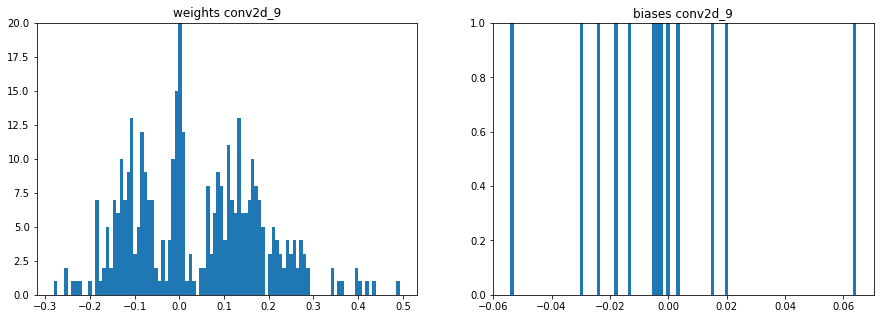

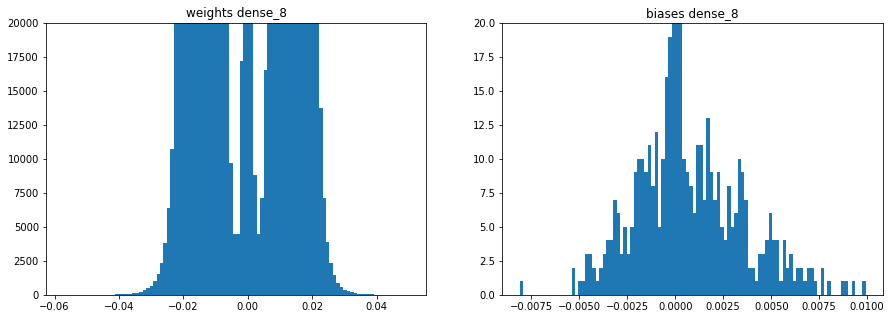

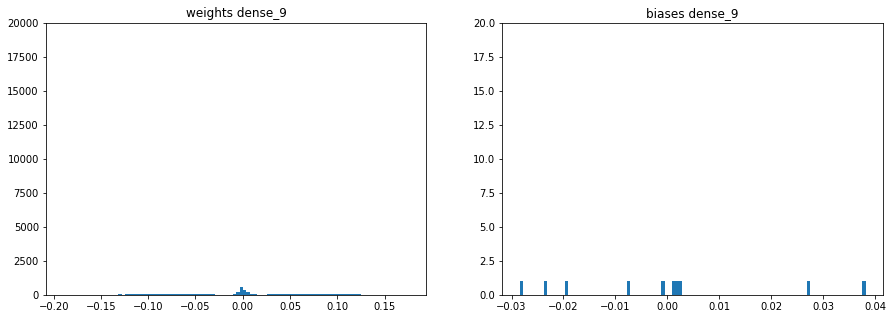

In [49]:
plot_wb(dsd_model.model)
wb_non_zero_percentage(dsd_model.model)

# II/ Train on sparse

In [41]:
dsd_model.train_on_sparse = True
dsd_model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=["accuracy"])

In [42]:
dsd_model.fit(train_x, train_y, epochs=3, callbacks=[UpdateMasks()])

Epoch 1/3
1875/1875 [==============================] - 186s 98ms/step - loss: 0.1257 - accuracy: 0.9624
Epoch 2/3
1875/1875 [==============================] - 203s 107ms/step - loss: 0.0883 - accuracy: 0.9727
Epoch 3/3
1875/1875 [==============================] - 180s 95ms/step - loss: 0.0744 - accuracy: 0.9769


Percentage of non-zero value conv2d_9: w = 100.0 | b = 100.0
Percentage of non-zero value dense_8: w = 100.0 | b = 100.0
Percentage of non-zero value dense_9: w = 100.0 | b = 100.0


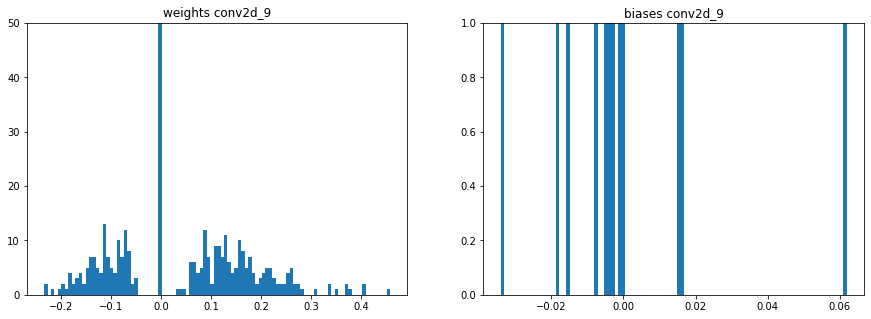

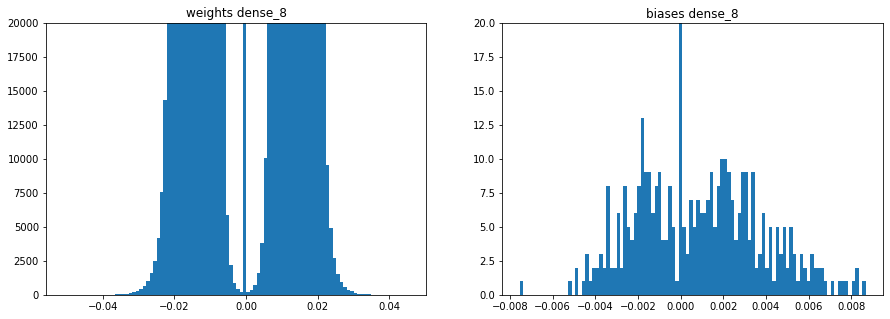

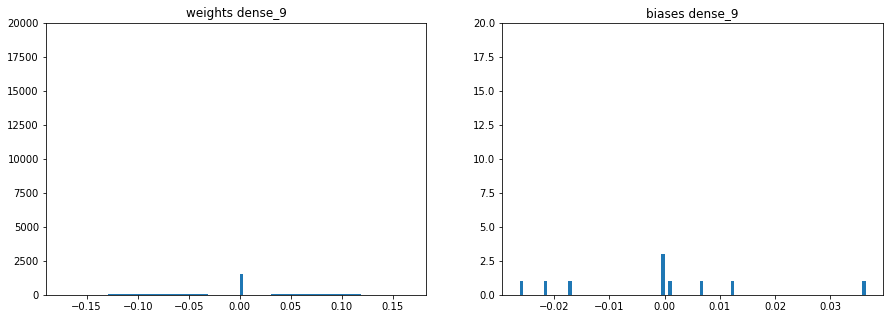

In [45]:
plot_wb(dsd_model.model)
wb_non_zero_percentage(dsd_model.model)

# III/ Train on Dense

In [46]:
dsd_model.train_on_sparse = False
dsd_model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

In [47]:
dsd_model.fit(train_x, train_y, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0718 - accuracy: 0.9774
Epoch 2/2
1875/1875 [==============================] - 159s 85ms/step - loss: 0.0544 - accuracy: 0.9831


Percentage of non-zero value conv2d_9: w = 100.0 | b = 100.0
Percentage of non-zero value dense_8: w = 100.0 | b = 100.0
Percentage of non-zero value dense_9: w = 100.0 | b = 100.0


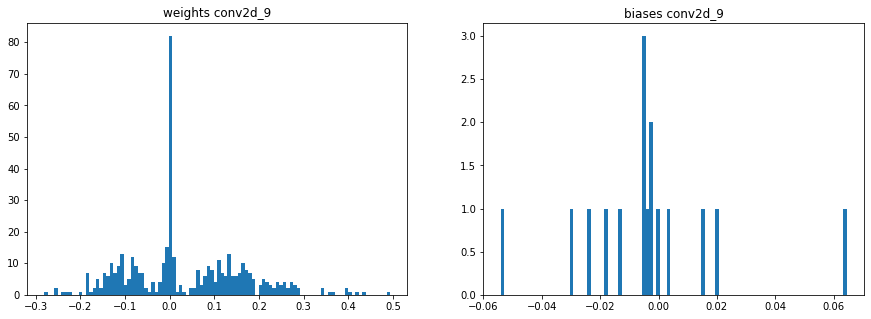

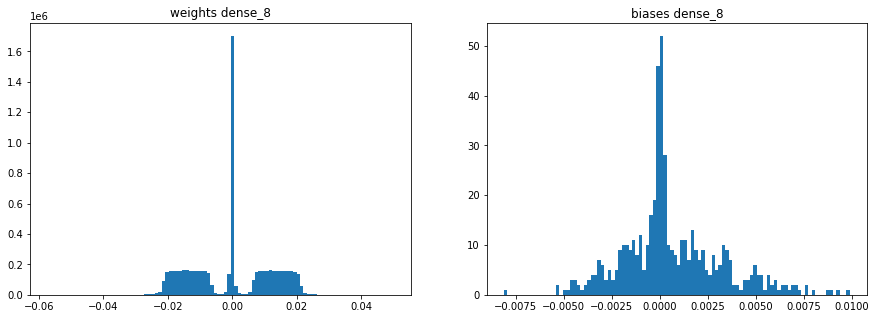

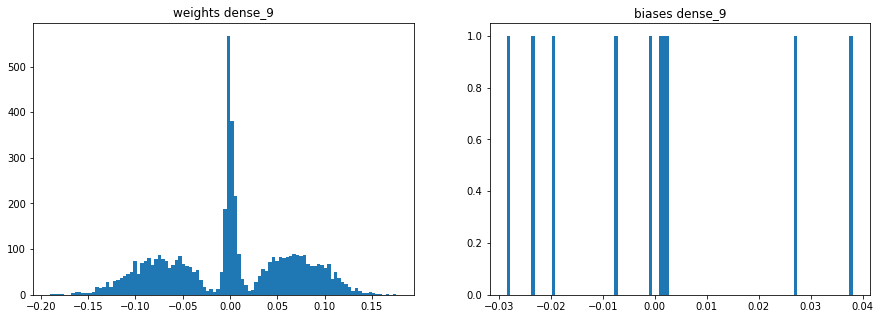

In [52]:
plot_wb(dsd_model.model)
wb_non_zero_percentage(dsd_model.model)